<a href="https://colab.research.google.com/github/hrbae/LG_AI_training/blob/main/M2_System%20Optimization%20by%20ML/Practice/Practice_2_3_Deep_Learning_Parameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ray

In [ ]:
%matplotlib inline

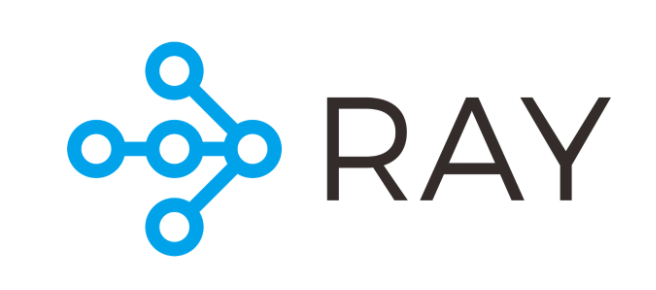



*   Ray Tune을 이용한 딥러닝 하이퍼 파라미터 튜닝



---

1.  Python 병렬처리의 한계

*   빠른 하이퍼파라미터 튜닝을 위해 주로 병렬처리를 수행하며, 이 경우 MP(Multi-Processing)을 주로 사용
*   MP  라이브러리를 사용하기 위해 기존에 작성한 코드를 수정이 필요하며, 익숙하지 않은 사용자 입장에서 분산처리하기 쉽지 않음



2.   Ray란?

*   버클리 대학의 RISE 연구실에서 만들어졌으며, Apache Arrow를 사용해 데이터를 효율적으로 처리한다는 장점이 있음
*   머신러닝/딥러닝을 위해 개발되었지만 다양하게 활용할 수 있음

3.   Ray의 장점

*   분산 어플리케이션을 만들기 위해 단순하고 범용적인 API를 제공하는 라이브러리
*   기존 사용자가 작성한 코드에 병렬처리를 위한 코드를 추가하면 쉽게 병렬처리가 가능하다는 점이 가장 큰장점
*   로컬 환경, 클라우드의 쿠버네티스(AWS, GCP, Azure) 환경, 온프레미스 쿠버네티스 등 다양한 환경에서 사용할 수 있음









*   딥러닝에서 Ray의 역활

---





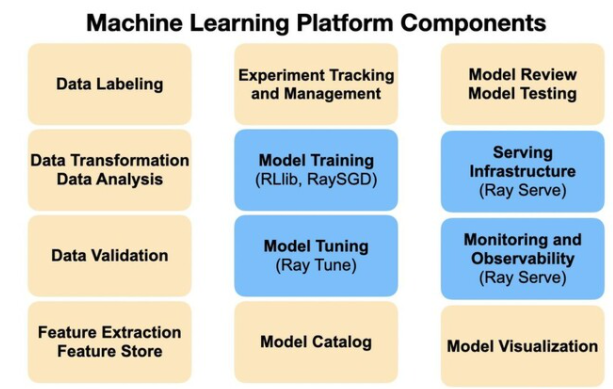

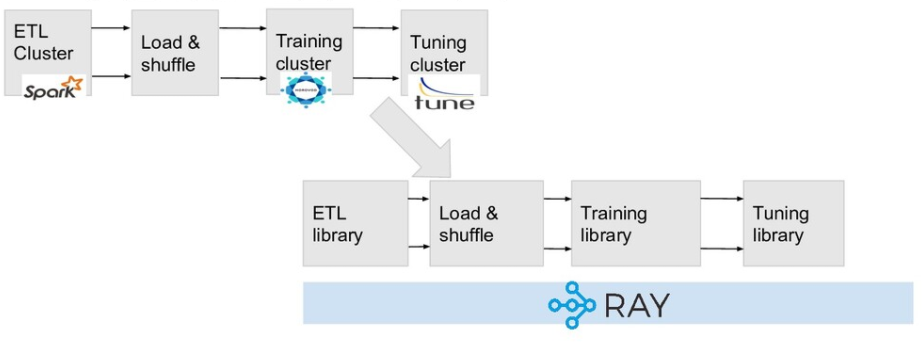

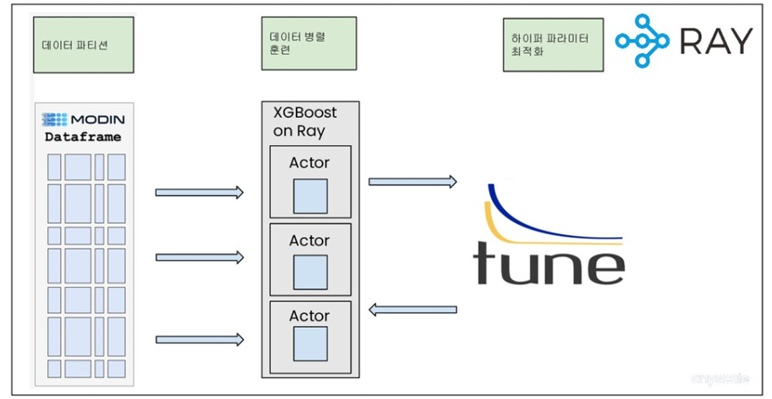

In [ ]:
from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [ ]:
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

In [ ]:
class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def train_cifar(config, checkpoint_dir=None, data_dir=None):
    net = Net(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset, testset = load_data(data_dir)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [ ]:
def test_accuracy(net, device="cpu"):
    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [ ]:
config = {
    "l1": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "l2": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([8, 16])
}

In [ ]:
def main(num_samples=10, max_num_epochs=3, gpus_per_trial=2):
    data_dir = os.path.abspath("./data")
    load_data(data_dir)
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_cifar, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=10, max_num_epochs=1, gpus_per_trial=0)

Files already downloaded and verified
Files already downloaded and verified


2021-10-13 16:06:00,624	WARNING experiment.py:303 -- No name detected on trainable. Using DEFAULT.
2021-10-13 16:06:00,626	INFO registry.py:67 -- Detected unknown callable for trainable. Converting to class.
2021-10-13 16:06:00,672	INFO logger.py:599 -- pip install 'ray[tune]' to see TensorBoard files.
2021-10-13 16:06:00,674	WARNING callback.py:117 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Memory usage on this node: 1.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects
Result logdir: /root/ray_results/DEFAULT_2021-10-13_16-06-00
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+---------------------+----------+-------+--------------+------+------+-------------+
| Trial name          | status   | loc   |   batch_size |   l1 |   l2 |          lr |
|---------------------+----------+-------+--------------+------+------+-------------|
| DEFAULT_7573a_00000 | RUNNING  |       |            8 |  256 |   64 | 0.00294565  |
| DEFAULT_7573a_00001 | PENDING  |       |            4 |  128 |   16 | 0.000169962 |
| DEFAULT_7573a_00002 | PENDING  |       |            2 |  128 |    4 | 0.00132254  |
| DEFAULT_7573a_00003 | PENDING  |       |            2 |  128 |   64 | 0.00940533  |
| DEFAULT_7573a_00004 | PENDING  |       |            2 |   32 |   32 | 0.000193933 |
| DEFA

(pid=1029) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=1029)   cpuset_checked))
(pid=1029) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=1029)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


== Status ==
Memory usage on this node: 1.8/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects
Result logdir: /root/ray_results/DEFAULT_2021-10-13_16-06-00
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+---------------------+----------+-------+--------------+------+------+-------------+
| Trial name          | status   | loc   |   batch_size |   l1 |   l2 |          lr |
|---------------------+----------+-------+--------------+------+------+-------------|
| DEFAULT_7573a_00000 | RUNNING  |       |            8 |  256 |   64 | 0.00294565  |
| DEFAULT_7573a_00001 | PENDING  |       |            4 |  128 |   16 | 0.000169962 |
| DEFAULT_7573a_00002 | PENDING  |       |            2 |  128 |    4 | 0.00132254  |
| DEFAULT_7573a_00003 | PENDING  |       |            2 |  128 |   64 | 0.00940533  |
| DEFAULT_7573a_00004 | PENDING  |       |            2 |   32 |   32 | 0.000193933 |
| DEFA

(pid=1030) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=1030)   cpuset_checked))
(pid=1030) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=1030)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


== Status ==
Memory usage on this node: 1.8/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects
Result logdir: /root/ray_results/DEFAULT_2021-10-13_16-06-00
Number of trials: 10/10 (8 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------+------------+-------+--------------+------+------+-------------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |          lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+-------------+---------+------------+----------------------|
| DEFAULT_7573a_00001 | RUNNING    |       |            4 |  128 |   16 | 0.000169962 |         |            |                      |
| DEFAULT_7573a_00002 | PENDING    |       |            2 |  128 |    4 | 0.00132254  |         |            |                      |
| DEFAULT_

(pid=1277) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=1277)   cpuset_checked))
(pid=1277) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=1277)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


== Status ==
Memory usage on this node: 1.8/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects
Result logdir: /root/ray_results/DEFAULT_2021-10-13_16-06-00
Number of trials: 10/10 (7 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------+------------+-------+--------------+------+------+-------------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |          lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+-------------+---------+------------+----------------------|
| DEFAULT_7573a_00002 | RUNNING    |       |            2 |  128 |    4 | 0.00132254  |         |            |                      |
| DEFAULT_7573a_00003 | PENDING    |       |            2 |  128 |   64 | 0.00940533  |         |            |                      |
| DEFAULT_

(pid=1403) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=1403)   cpuset_checked))
(pid=1403) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=1403)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


== Status ==
Memory usage on this node: 1.8/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects
Result logdir: /root/ray_results/DEFAULT_2021-10-13_16-06-00
Number of trials: 10/10 (6 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------+------------+-------+--------------+------+------+-------------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |          lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+-------------+---------+------------+----------------------|
| DEFAULT_7573a_00003 | RUNNING    |       |            2 |  128 |   64 | 0.00940533  |         |            |                      |
| DEFAULT_7573a_00004 | PENDING    |       |            2 |   32 |   32 | 0.000193933 |         |            |                      |
| DEFAULT_

(pid=1533) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=1533)   cpuset_checked))
(pid=1533) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=1533)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


== Status ==
Memory usage on this node: 1.8/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects
Result logdir: /root/ray_results/DEFAULT_2021-10-13_16-06-00
Number of trials: 10/10 (5 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------+------------+-------+--------------+------+------+-------------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |          lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+-------------+---------+------------+----------------------|
| DEFAULT_7573a_00004 | RUNNING    |       |            2 |   32 |   32 | 0.000193933 |         |            |                      |
| DEFAULT_7573a_00005 | PENDING    |       |           16 |    8 |   32 | 0.000130469 |         |            |                      |
| DEFAULT_

(pid=1657) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=1657)   cpuset_checked))
(pid=1657) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=1657)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


== Status ==
Memory usage on this node: 1.8/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects
Result logdir: /root/ray_results/DEFAULT_2021-10-13_16-06-00
Number of trials: 10/10 (4 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------+------------+-------+--------------+------+------+-------------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |          lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+-------------+---------+------------+----------------------|
| DEFAULT_7573a_00005 | RUNNING    |       |           16 |    8 |   32 | 0.000130469 |         |            |                      |
| DEFAULT_7573a_00006 | PENDING    |       |           16 |   64 |   16 | 0.000123114 |         |            |                      |
| DEFAULT_

(pid=1769) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=1769)   cpuset_checked))
(pid=1769) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=1769)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


== Status ==
Memory usage on this node: 1.8/12.7 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects
Result logdir: /root/ray_results/DEFAULT_2021-10-13_16-06-00
Number of trials: 10/10 (3 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------+------------+-------+--------------+------+------+-------------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |          lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+-------------+---------+------------+----------------------|
| DEFAULT_7573a_00006 | RUNNING    |       |           16 |   64 |   16 | 0.000123114 |         |            |                      |
| DEFAULT_7573a_00007 | PENDING    |       |            2 |    4 |  256 | 0.0269059   |         |            |                      |
| DEFAULT_

(pid=1883) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=1883)   cpuset_checked))
(pid=1883) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=1883)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


== Status ==
Memory usage on this node: 1.8/12.7 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects
Result logdir: /root/ray_results/DEFAULT_2021-10-13_16-06-00
Number of trials: 10/10 (2 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------+------------+-------+--------------+------+------+-------------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |          lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+-------------+---------+------------+----------------------|
| DEFAULT_7573a_00007 | RUNNING    |       |            2 |    4 |  256 | 0.0269059   |         |            |                      |
| DEFAULT_7573a_00008 | PENDING    |       |            2 |   64 |    8 | 0.000495569 |         |            |                      |
| DEFAULT_

(pid=2009) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=2009)   cpuset_checked))
(pid=2009) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=2009)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


== Status ==
Memory usage on this node: 1.8/12.7 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects
Result logdir: /root/ray_results/DEFAULT_2021-10-13_16-06-00
Number of trials: 10/10 (1 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------+------------+-------+--------------+------+------+-------------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |          lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+-------------+---------+------------+----------------------|
| DEFAULT_7573a_00008 | RUNNING    |       |            2 |   64 |    8 | 0.000495569 |         |            |                      |
| DEFAULT_7573a_00009 | PENDING    |       |           16 |   16 |    8 | 0.00363374  |         |            |                      |
| DEFAULT_

(pid=2133) /usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(pid=2133)   cpuset_checked))
(pid=2133) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
(pid=2133)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


== Status ==
Memory usage on this node: 1.8/12.7 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects
Result logdir: /root/ray_results/DEFAULT_2021-10-13_16-06-00
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+---------------------+------------+-------+--------------+------+------+-------------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 |   l2 |          lr |    loss |   accuracy |   training_iteration |
|---------------------+------------+-------+--------------+------+------+-------------+---------+------------+----------------------|
| DEFAULT_7573a_00009 | RUNNING    |       |           16 |   16 |    8 | 0.00363374  |         |            |                      |
| DEFAULT_7573a_00000 | TERMINATED |       |            8 |  256 |   64 | 0.00294565  | 1.47889 |     0.4581 |                    1 |
| DEFAULT_7573a_00001

2021-10-13 16:18:19,835	INFO tune.py:617 -- Total run time: 739.21 seconds (739.01 seconds for the tuning loop).


Result for DEFAULT_7573a_00009:
  accuracy: 0.4234
  date: 2021-10-13_16-18-19
  done: true
  experiment_id: 5add7b2460de479594d1ee1dd310839a
  hostname: 1fa2e9174d25
  iterations_since_restore: 1
  loss: 1.5731862915039063
  node_ip: 172.28.0.2
  pid: 2133
  should_checkpoint: true
  time_since_restore: 29.900702953338623
  time_this_iter_s: 29.900702953338623
  time_total_s: 29.900702953338623
  timestamp: 1634141899
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 7573a_00009
  
== Status ==
Memory usage on this node: 1.5/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 1.000: None
Resources requested: 0/2 CPUs, 0/0 GPUs, 0.0/7.34 GiB heap, 0.0/3.67 GiB objects
Result logdir: /root/ray_results/DEFAULT_2021-10-13_16-06-00
Number of trials: 10/10 (10 TERMINATED)
+---------------------+------------+-------+--------------+------+------+-------------+---------+------------+----------------------+
| Trial name          | status     | loc   |   batch_size |   l1 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Best trial test set accuracy: 0.4593
